# Deep Learning haciendo uso de CNN: ResNet
---
### Trabajo Final del curso Machine Learning
### Docente: M.Sc. Richard Fernández 

**Integrantes**:
- Lucas Parodi
- Eduardo Contreras
- Dante Moreno




## 1. Introducción

Deep Learning es un subcampo de Machine Learning, enfocado en algoritmos inspirados por la estructura y funcionalidad de las redes neuronales artificiales $^{[1]}$. El número de capas en una red neuronal es conocido como la profundidad de la red; y Deep Learning aprovecha la capacidad del hardware actual para utilizar redes neuronales más profundas que antes. En las últimas décadas, Deep Learning ha demostrado gran potencial gracias a su habilidad de manejar grandes volúmenes de data. $^{[2]}$

El propósito de este trabajo es estudiar y aplicar Deep Learning utilizando redes convolucionales. Para esto, implementamos redes residuales, conocidas también como ResNet, en un caso de estudio. Luego, analizamos los resultados obtenidos para extraer conclusiones y recomendaciones pertinentes al caso de estudio.

## 2. Marco Teórico

### 2.1. Redes Neuronales Convolucionales

En 2012, la visión computacional presenció un gran avance cuando un grupo de investigadores de la Universidad de Toronto desarrolló AlexNet, un sistema que se basaba en redes convolucionales artificiales, o CNN por sus siglas en inglés. $^{[2]}$ Este modelo superó a los mejores algoritmos de reconocimiento de imágenes por un amplio margen.

<img src='https://editor.analyticsvidhya.com/uploads/183560_qcMBDPuKpDvICcdd.png'>

*Convolutional Neural Network* $^{[2]}$

### 2.2. Aprendizaje Residual

El uso de redes neuronales convolucionales ha generado un gran avance en el estudio de visión computacional. Aunque crear redes más profundas, es decir, con más capas, podría parecer una forma de mejorar los resultados, en realidad vuelve más díficil el entrenamiento. Esto es llamado un problema de degradación: conforme la profundidad de la red aumenta, su resultado en accuracy disminuye rápidamente$^{[3]}$.

### 2.3. Redes Residuales

<p>Una red neuronal residual, también conocida como ResNet, es una red neuronal artificial que se inspira en el hecho biológico de que algunas neuronas se conectan con neuronas en capas no necesariamente contiguas, saltando capas intermedias.</p>
<img src='https://datascience.eu/wp-content/uploads/2020/09/image-27.png'>
<p>Una razón de peso para saltar capas es evitar los gradientes que se desvanecen y cuestiones similares. Como el gradiente se retropropaga a las capas anteriores, este proceso repetido puede hacer que el gradiente sea extremadamente pequeño.</p>
<p>El salto elimina las complicaciones de la red, haciéndola más simple, usando muy pocas capas durante la etapa de entrenamiento inicial. Acelera el aprendizaje por diez veces, minimizando el efecto de la desaparición de los gradientes. Después de esto, la red eventualmente vuelve a poner las capas hábiles mientras aprende el espacio de las características.</p>

## 3. Caso de Estudio

El dataset UISketch$^{[8]}$ contiene imágenes de bosquejos de diferentes elementos que pertenecen a la interfaz de usuario. El conjunto de datos contiene los atributos:
* $name$: Nombre del archivo donde se guarda la imagen del bosquejo de elemento de UI.
* $label$: Etiqueta con la que se identifica el tipo de elemento de UI.
* $medium$: Medio con el cual se desarrolló el bosquejo; puede ser digital o papel.
* $device$: Dispositivo.

### 3.1. Exploración de datos

In [1]:
# Librerías:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

Leemos el dataset *labels*, que consta de 19000 instancias de bosquejos de elementos de una interfaz de usuario.

In [2]:
data = pd.read_csv('data/labels.csv')
print("Filas: ", len(data))
data.head()

Filas:  19000


,name,label,medium,device
0,alert/0000.jpg,alert,digital,stylus
1,alert/0001.jpg,alert,digital,stylus
2,alert/0002.jpg,alert,paper,pen
3,alert/0003.jpg,alert,digital,stylus
4,alert/0004.jpg,alert,paper,pen


Con los nombres de los archivos .jpg que guardan las imágenes, podemos leer también las imágenes.

In [3]:
imgs = []
for r in data['name']:
    img = cv2.imread('data/%s'%str(r))
    imgs.append(img)
data["image"] = imgs

Podemos ver, por ejemplo, un bosquejo que corresponde a la fila:

label | medium | device
--- | --- | ---
alert | paper | pen

Es decir, una alerta dibujada en papel, con un lápiz.

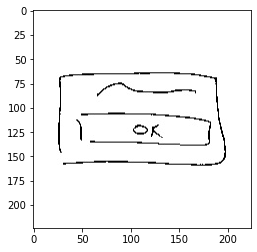

In [4]:
plt.imshow(imgs[2]) # Paper

Podemos examinar a profundidad las variables nominales de este conjunto de datos:

In [5]:
columnas = data.columns
for c in columnas[1:4]:
    print(f'{c} \t: {len(pd.unique(data[c]))} valores únicos')

label 	: 21 valores únicos
medium 	: 2 valores únicos
device 	: 6 valores únicos


Podemos comparar las variables *medium* y *device* para analizar si existe alguna relación entre estas.

medium  digital  paper
device                
finger       65      0
mouse       131      0
pen           0   4015
pencil        0   1490
stylus    13276      0


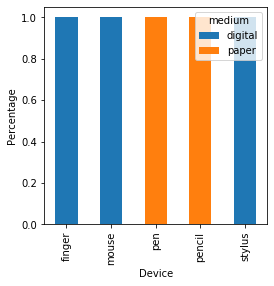

In [6]:
print(pd.crosstab(data["device"],data["medium"]))
Medium = pd.crosstab(data["device"],data["medium"])
Medium.div(Medium.sum(1).astype(float),axis=0).plot(kind="bar",stacked=True,figsize=(4,4))
plt.xlabel("Device")
plt.ylabel("Percentage")
plt.show()

La variable *medium* y *paper* están claramente relacionadas.
Aquellos bosquejos realizados en papel fueron hechos con las herramientas esperadas: lápiz o lapicero. Por otro lado, el medio digital permite que los diseñadores usen otros dispositivos, como su dedo, mouse, o *stylus* (similar a un lápiz, para dibujos digitales).

Además, notamos que se identificaron únicamente 5 valores únicos en *device*, por lo que el sexto valor señalado por la función $unique()$ podría ser el resultado de valores nulos. Para eso, vemos un resumen de los datos:

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19000 entries, 0 to 18999
Data columns (total 5 columns):
name      19000 non-null object
label     19000 non-null object
medium    19000 non-null object
device    18977 non-null object
image     19000 non-null object
dtypes: object(5)
memory usage: 742.3+ KB


La columna *device* tiene 23 datos vacíos. Por lo tanto, si deseamos usarla, necesitamos llenar esos datos.

### 3.2. Preprocesamiento

In [9]:
data['image'].values.shape

(19000,)

Los datos de entrada serán las imágenes:

In [17]:
X = np.array(data.iloc[:,-1].values) #.to_numpy()
y = np.array(data['medium'].values) #.to_numpy()
print(X.shape)
print(y.shape)
print(y[:5])

(19000,)
(19000,)
['digital' 'digital' 'paper' 'digital' 'paper']


In [18]:
lut = {'digital': 0, 'paper': 1}
for i in range(len(y)):
    y[i] = lut[y[i]]
y[:5]

array([0, 0, 1, 0, 1], dtype=object)

Para su ingreso en ResNet, necesitamos asegurar que $X$ sea considerado un arreglo de 4 dimensiones:

In [28]:
X = np.array([x for x in X])
X.shape

(19000, 224, 224, 3)

In [32]:
y = y.reshape((19000,1))
y.shape

(19000, 1)

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

print(f'Entrenamiento: {X_train[0]}, donde cada uno es de dimensiones {X_train[0].shape}')

Entrenamiento: [[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]], donde cada uno es de dimensiones (224, 224, 3)


### 3.3. ResNet

In [35]:
from tensorflow import keras

In [37]:
input_shape = X_train.shape[1:]
classes = 2

print(f'Input Shape: {input_shape}')
print(f'Clases posibles: {classes}')

Input Shape: (224, 224, 3)
Clases posibles: 2


In [38]:
model = keras.applications.ResNet50(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=input_shape,
    pooling=None,
    classes=classes)

In [39]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

In [ ]:
model.fit(X_train, y_train)

Train on 15200 samples
  512/15200 [>.............................] - ETA: 4:27:03 - loss: 2.2395

### 3.1. Resultados del modelo

## 4. Conclusiones

## 5. Recomendaciones

## Referencias bibliográficas:

1. Brownlee, J. (16 de agosto de 2019). What is Deep Learning?. *Machine Learning Mastery* Recuperado de: https://machinelearningmastery.com/what-is-deep-learning/ 
2. Mandal, M. (1 de mayo de 2021). Introduction to Convolutional Neural Networks (CNN). *Analytics Vidha*. Recuperado de: https://www.analyticsvidhya.com/blog/2021/05/convolutional-neural-networks-cnn/
3. He, K., Zhang, X., Ren, S., & Sun, J. (2015). *Deep Residual Learning for Image Recognition* Recuperado de: https://arxiv.org/abs/1512.03385
4. Feng, V. (15 de julio de 2020). An Overview of ResNet and its Variants. *Towards Data Science*. Recuperado de: https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035
5. Mutjaba, H. (28 de septiembre de 2020). Introduction to Resnet or Residual Network. *Great Learning*. Recuperado de: https://www.mygreatlearning.com/blog/resnet/ 
6. Boesch, G. (29 de agosto de 2021). Deep Residual Networks (ResNet, ResNet50) – Guide in 2021 *Viso.ai*. Recuperado de: https://viso.ai/deep-learning/resnet-residual-neural-network/
7. TensorFlow (12 de Noviembre de 2021) *Trabajar con capas de preprocesamiento* Recuperado de: https://www.tensorflow.org/guide/keras/preprocessing_layers
8. Pandian, V. (2021). UISketch Dataset *Kaggle* Recuperado de: https://www.kaggle.com/vinothpandian/uisketch 